In [1]:
import os
import pandas as pd

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image, ImageFile
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

## PADCHEST: Scanner Shift

In [2]:

from sklearn.model_selection import train_test_split

# Import scikit-image for image loading
from skimage import io
import torch
import torch.nn as nn

# A necessary helper function to prevent crashes if an image file is missing.
def collate_fn_skip_none(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

def log_broken_image(filepath):
    """Safely appends a broken image path to a log file."""
    with open("broken_images.txt", "a") as f:
        f.write(f"{filepath}\n")

# --- 1. Dedicated Data Preparation Function ---
def prepare_padchest_csv(csv_file):
    """Loads and filters the PadChest CSV file."""
    print("Loading and preparing the master DataFrame...")
    df = pd.read_csv(csv_file, low_memory=False)

    # Filter out known invalid images, PA projection, and non-adults
    invalid_filenames = [ "216840111366964013829543166512013353113303615_02-092-190.png", "216840111366964013962490064942014134093945580_01-178-104.png", "216840111366964012989926673512011151082430686_00-157-045.png", "216840111366964012558082906712009327122220177_00-102-064.png", "216840111366964012959786098432011033083840143_00-176-115.png", "216840111366964012373310883942009152114636712_00-102-045.png", "216840111366964012487858717522009280135853083_00-075-001.png", "216840111366964012819207061112010307142602253_04-014-084.png", "216840111366964012989926673512011074122523403_00-163-058.png", "216840111366964013590140476722013058110301622_02-056-111.png", "216840111366964012339356563862009072111404053_00-043-192.png", "216840111366964013590140476722013043111952381_02-065-198.png", "216840111366964012819207061112010281134410801_00-129-131.png", "216840111366964013686042548532013208193054515_02-026-007.png", "216840111366964012989926673512011083134050913_00-168-009.png",]
    df = df[~df["ImageID"].isin(invalid_filenames)]
    df = df[df["Projection"] == "PA"].copy()
    df = df[df["Pediatric"] == "No"].copy()
    df = df[df["PatientSex_DICOM"].isin(["M", "F"])].copy()

    def process_labels(row_labels, target_label):
        if isinstance(row_labels, str):
            list_labels = row_labels.strip("[]").replace("'", "").split(',')
            list_labels = [label.strip() for label in list_labels]
            return target_label in list_labels
        return False

    df['exclude'] = df['Labels'].apply(lambda x: process_labels(x, 'exclude'))
    df['suboptimal study'] = df['Labels'].apply(lambda x: process_labels(x, 'suboptimal study'))
    df = df[~df['exclude']]
    df = df[~df['suboptimal study']]

    df["ScannerType"] = df["Manufacturer_DICOM"].apply(lambda x: "Phillips" if x == "PhilipsMedicalSystems" else "Imaging")
    df["pneumonia"] = df['Labels'].apply(lambda x: process_labels(x, 'pneumonia')).astype(int)

    return df

# --- 2. UPDATED PadChestDataset Class with Exact Loading ---
class PadChestDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, use_scanner_counterfactuals = False):
        self.df = df.reset_index(drop=True) # Reset index for clean slicing
        self.image_dir = image_dir
        self.transform = transform
        self.counterfactual_dir = "/vol/biomedic3/bglocker/mscproj/ms4824/stress-testing-framework/src/datasets/counterfactual-images/"
        self.use_scanner_counterfactuals = use_scanner_counterfactuals
        self.image_ids = self.df["ImageID"].values
        self.labels = self.df["pneumonia"].values
        self.patient_ids = self.df["PatientID"].values
        self.scanners = self.df["ScannerType"].values

    def __len__(self):
        return len(self.df)

    def read_image_as_pil(self, idx):
        if self.use_scanner_counterfactuals:
            original_scanner_type = "phillips" if self.scanners[idx] == "Phillips" else "imaging"
            image_path = os.path.join(self.counterfactual_dir, "scanner", original_scanner_type, self.image_ids[idx])
        else:
            image_path = os.path.join(self.image_dir, self.image_ids[idx])

        try:
            # Use scikit-image for robust loading
            img_array = io.imread(image_path, as_gray=True)
        except Exception:
            # Fallback to PIL for certain compressed formats
            ImageFile.LOAD_TRUNCATED_IMAGES = True
            pil_img = Image.open(image_path).convert('L')
            img_array = np.array(pil_img)
            ImageFile.LOAD_TRUNCATED_IMAGES = False

        # Normalize to 0-1 range
        max_val = img_array.max()
        if max_val > 0:
            img_array = img_array / max_val

        # Convert to PIL Image for torchvision transforms
        pil_image = Image.fromarray((img_array * 255).astype(np.uint8))

        return pil_image.convert("RGB")


    def __getitem__(self, idx):
        try:
            image = self.read_image_as_pil(idx)
        except Exception as e:
            image_path = os.path.join(self.image_dir, self.image_ids[idx])
            print(f"\nFATAL: Could not load image {image_path}. Error: {e}. Skipping.", flush=True)
            log_broken_image(image_path)
            return None

        image_tensor = self.transform(image) if self.transform else image

        # Only return the image tensor; labels are not needed for feature extraction
        return {'x': image_tensor}


def extract_features(model, dataloader, device):
    """
    Extracts features from the model for all data in the dataloader.
    """
    model.eval()
    features_list = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting Features"):
            if batch is None: continue
            inputs = batch['x'].to(device)
            # Pass through the feature extractor part of the model
            outputs = model(inputs)
            # The output of nn.Identity() is the tensor itself, flatten it
            features_list.append(outputs.cpu().numpy().reshape(inputs.size(0), -1))

    if not features_list:
        return np.array([])
        
    return np.concatenate(features_list, axis=0)



In [ ]:
from skimage import io
import torch
import torch.nn as nn

import sys
sys.path.append("/vol/biomedic3/bglocker/mscproj/ms4824/stress-testing-framework/src")
from datasets.data import PadChestDataModule

CSV_FILE = Path("/vol/biodata/data/chest_xray/BIMCV-PADCHEST/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv")
IMAGE_DIR = Path("/vol/biodata/data/chest_xray/BIMCV-PADCHEST/images")
BATCH_SIZE = 64
CHECKPOINT_DIR = "model_checkpoints_patient_split"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


data_module = PadChestDataModule(
                csv_file=CSV_FILE,
                image_dir=IMAGE_DIR,
                batch_size=BATCH_SIZE,
            )
data_module.setup(split_values=("Imaging","Phillips"),split_on="ScannerType", test_limit=1000)

dataloaders = {
    'test_a': data_module.test_dataloader_a(),
    'test_b': data_module.test_dataloader_b(),
    'cf_a':data_module.cf_a_dataloader(),
    'cf_b': data_module.cf_b_dataloader()
}

# --- Model Setup for Feature Extraction ---
print("\nSetting up Model for feature extraction...")

MODEL_TYPE = "resnet" # resnet,vit, densenet
if MODEL_TYPE == "resnet":
    model = models.resnet50(weights=None)
    model.fc = nn.Identity()
if MODEL_TYPE == "vit":
    model = models.vit_b_16(weights=None)
    model.heads.head = nn.Identity()
if MODEL_TYPE == "densenet":
    model = models.densenet121(weights=None) 
    model.classifier = nn.Identity()
print(MODEL_TYPE)

model = model.to(device)

# --- Load Pre-trained Weights ---
CHECKPOINT_TO_LOAD = "model_checkpoints_patient_split/resnet50_final_trained_on_imaging25.pth"
if CHECKPOINT_TO_LOAD and os.path.exists(CHECKPOINT_TO_LOAD):
    print(f"\n--- Loading Model From Checkpoint: {CHECKPOINT_TO_LOAD} ---")
    try:
  
        if MODEL_TYPE == "resnet":
            classifier_name = 'fc'
            load_model = models.resnet50(weights=None)
            num_ftrs = load_model.fc.in_features
            load_model.fc = nn.Linear(num_ftrs, 2)
        elif MODEL_TYPE == "vit":
            classifier_name = 'heads.head'
            load_model = models.vit_b_16(weights=None)
            num_ftrs = load_model.heads.head.in_features
            load_model.heads.head = nn.Linear(num_ftrs, 2)
        elif MODEL_TYPE == "densenet":
            classifier_name = 'classifier'
            load_model = models.densenet121(weights=None)
            num_ftrs = load_model.classifier.in_features
            load_model.classifier = nn.Linear(num_ftrs, 2)
        else:
            raise ValueError(f"Unsupported MODEL_TYPE for checkpoint loading: {MODEL_TYPE}")

        # Load the saved state dictionary into the temporary model
        state_dict = torch.load(CHECKPOINT_TO_LOAD, map_location=device)
        load_model.load_state_dict(state_dict)

        model.load_state_dict({k: v for k, v in load_model.state_dict().items() if classifier_name not in k}, strict=False)
        
        print("--- Checkpoint Loaded Successfully (Feature Layers Only) ---\n")

    except Exception as e:
        print(f"\n--- ERROR: Could not load checkpoint. Using default ImageNet weights. Error: {e} ---\n")
else:
    print(f"\n--- WARNING: Checkpoint file not found. Using default ImageNet weights. ---\n")

    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda:0
Loading and preparing the master DataFrame...
Performing patient-aware data split...

Splitting on attribute: 'ScannerType'
Group A ('in-distribution'): Imaging
Group B ('out-of-distribution'): Phillips

Training samples (Group A): 38943
Validation samples (Group A): 4241
OOD Validation samples (Group B): 2962
Test samples (Group A): 1000
Test samples (Group B): 1000


--- Initial Label Distribution in Each Dataset ---
Test (Group A) Label Distribution (pneumonia):
pneumonia
0    0.976
1    0.024
Name: proportion, dtype: float64

Test (Group B) Label Distribution (pneumonia):
pneumonia
0    0.928
1    0.072
Name: proportion, dtype: float64
----------------------------------------

--- Creating Manipulated Versions of Test Set A ---

Created 'Test A Remove 0.75 Positive'. Size: 994
Distribution:
pneumonia
0    0.981891
1    0.018109
Name: proportion, dtype: float64

Created 'Test

In [ ]:
# --- Extract Features for all datasets ---
all_features = {}
for name, loader in dataloaders.items():
    print(f"Processing dataset: {name}")
    all_features[name] = extract_features(model, loader, device)

# --- Apply PCA ---
print("\nApplying PCA...")
labels = []
feature_stack = []
for name, features in all_features.items():
    labels.extend([name] * features.shape[0])
    feature_stack.append(features)

combined_features = np.vstack(feature_stack)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(combined_features)

print(f"Explained variance ratio of first 5 PCs: {pca.explained_variance_ratio_}")

# --- Create DataFrame for Plotting ---
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(5)])
pca_df['datasource'] = labels



Processing dataset: test_a


Extracting Features: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Processing dataset: test_b


Extracting Features: 100%|██████████| 15/15 [00:40<00:00,  2.71s/it]


Processing dataset: cf_a


Extracting Features: 100%|██████████| 16/16 [00:03<00:00,  4.74it/s]


Processing dataset: cf_b


Extracting Features: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]



Applying PCA...
Explained variance ratio of first 5 PCs: [0.112523   0.07772078 0.04226424 0.03594626 0.02733213]
Generating density plots...


Generating density plots...


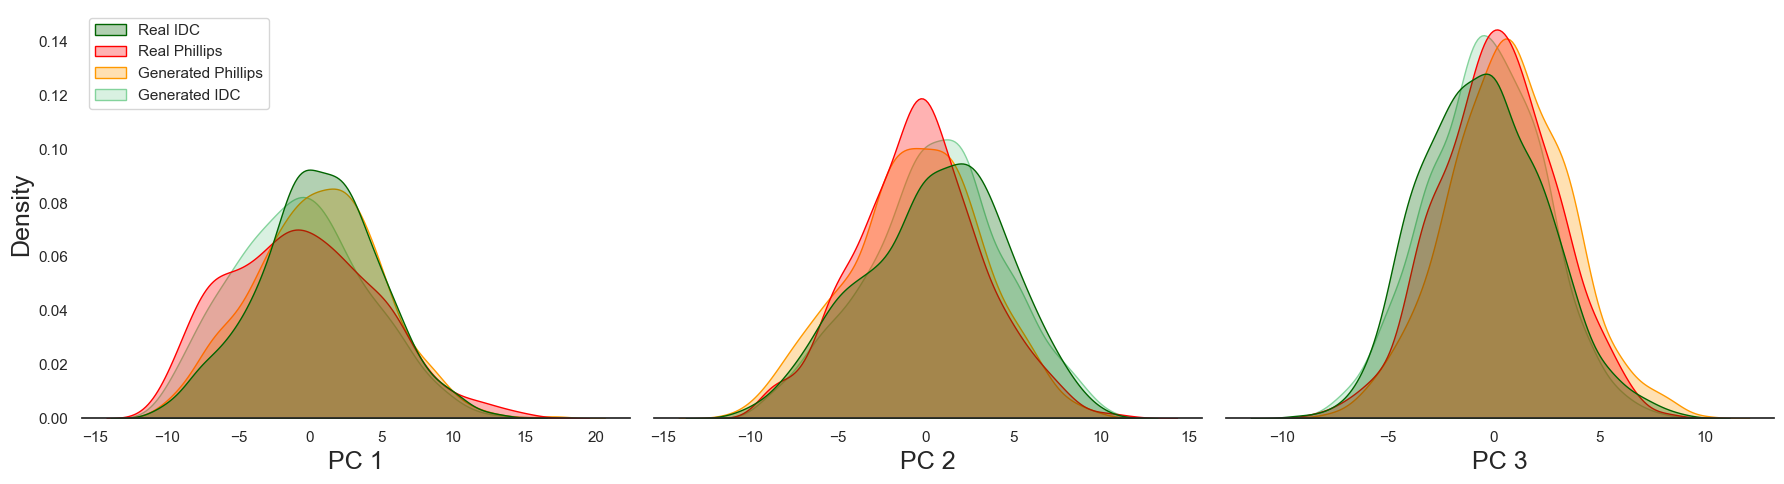

In [ ]:
# --- Generate Plots ---
print("Generating density plots...")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pca_df['datasource'] = pca_df['datasource'].replace({
    'cf_a': 'Generated Phillips',
    'cf_b': 'Generated IDC',
    'test_a': 'Real IDC',
    'test_b': 'Real Phillips'
})

palette = {
    'Real Phillips': 'red',
    'Real IDC': '#006400',  # Dark green
    'Generated IDC': '#84d39c', # Light green
    'Generated Phillips': '#ff9900'  # Orange
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ax in enumerate(axes, start=1):
    sns.kdeplot(
        data=pca_df,
        x=f'PC{i}',
        hue='datasource',
        palette=palette,
        fill=True,
        common_norm=False,
        alpha=0.3,
        ax=ax
    )
    ax.set_xlabel(f'PC {i}', fontsize=18)
    if i == 1:
        ax.set_ylabel('Density', fontsize=18)
    else:
        ax.set_ylabel('')
    sns.despine(ax=ax, left=True)
    if i != 1:
        ax.get_legend().remove()
    else:
        leg = ax.get_legend()
        leg.set_title('')
        leg.get_frame().set_facecolor('white')
        leg.set_bbox_to_anchor((0, 1))  # Top left corner of last subplot
        leg.set_loc('upper left')

plt.tight_layout()
plt.savefig("pca_padchest_scanner.pdf")
plt.show()


## PADCHEST: Sex Shift

In [32]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split

# Import scikit-image for image loading
from skimage import io
import torch
import torch.nn as nn

import sys
sys.path.append("/vol/biomedic3/bglocker/mscproj/ms4824/stress-testing-framework/src")
from datasets.data import PadChestDataModule

CSV_FILE = Path("/vol/biodata/data/chest_xray/BIMCV-PADCHEST/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv")
IMAGE_DIR = Path("/vol/biodata/data/chest_xray/BIMCV-PADCHEST/images")
BATCH_SIZE = 64
CHECKPOINT_DIR = "model_checkpoints_patient_split"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


data_module = PadChestDataModule(
                csv_file=CSV_FILE,
                image_dir=IMAGE_DIR,
                batch_size=BATCH_SIZE,
            )
data_module.setup(split_values=("M","F"),split_on="Sex", test_limit=1000)

dataloaders = {
    'test_a': data_module.test_dataloader_a(),
    'test_b': data_module.test_dataloader_b(),
    'cf_a':data_module.cf_a_dataloader(),
    'cf_b': data_module.cf_b_dataloader()
}

# --- Model Setup for Feature Extraction ---
print("\nSetting up Model for feature extraction...")

MODEL_TYPE = "resnet" # resnet,vit, densenet
if MODEL_TYPE == "resnet":
    model = models.resnet50(weights=None)
    model.fc = nn.Identity()
if MODEL_TYPE == "vit":
    model = models.vit_b_16(weights=None)
    model.heads.head = nn.Identity()
if MODEL_TYPE == "densenet":
    model = models.densenet121(weights=None) 
    model.classifier = nn.Identity()
print(MODEL_TYPE)

model = model.to(device)

# --- Load Pre-trained Weights ---
CHECKPOINT_TO_LOAD = "model_checkpoints_patient_split/resnet_trained_on_M_split_on_Sex_seed_34_epoch_15.pth"
if CHECKPOINT_TO_LOAD and os.path.exists(CHECKPOINT_TO_LOAD):
    print(f"\n--- Loading Model From Checkpoint: {CHECKPOINT_TO_LOAD} ---")
    try:
        # Determine the name of the final classifier layer and create a temporary model
        # with the original output layer to correctly load the state dictionary.
        # This assumes the saved model was for a 2-class classification task.
        if MODEL_TYPE == "resnet":
            classifier_name = 'fc'
            load_model = models.resnet50(weights=None)
            num_ftrs = load_model.fc.in_features
            load_model.fc = nn.Linear(num_ftrs, 2)
        elif MODEL_TYPE == "vit":
            classifier_name = 'heads.head'
            load_model = models.vit_b_16(weights=None)
            num_ftrs = load_model.heads.head.in_features
            load_model.heads.head = nn.Linear(num_ftrs, 2)
        elif MODEL_TYPE == "densenet":
            classifier_name = 'classifier'
            load_model = models.densenet121(weights=None)
            num_ftrs = load_model.classifier.in_features
            load_model.classifier = nn.Linear(num_ftrs, 2)
        else:
            raise ValueError(f"Unsupported MODEL_TYPE for checkpoint loading: {MODEL_TYPE}")

        # Load the saved state dictionary into the temporary model
        state_dict = torch.load(CHECKPOINT_TO_LOAD, map_location=device)
        load_model.load_state_dict(state_dict)

        # *** THE CORRECTED LINE ***
        # Load the weights into your feature extraction model, excluding the final classifier layer
        model.load_state_dict({k: v for k, v in load_model.state_dict().items() if classifier_name not in k}, strict=False)
        
        print("--- Checkpoint Loaded Successfully (Feature Layers Only) ---\n")

    except Exception as e:
        print(f"\n--- ERROR: Could not load checkpoint. Using default ImageNet weights. Error: {e} ---\n")
else:
    print(f"\n--- WARNING: Checkpoint file not found. Using default ImageNet weights. ---\n")

    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda:0
Loading and preparing the master DataFrame...
Performing patient-aware data split...

Splitting on attribute: 'Sex'
Group A ('in-distribution'): M
Group B ('out-of-distribution'): F

Training samples (Group A): 31646
Validation samples (Group A): 3482
OOD Validation samples (Group B): 3721
Test samples (Group A): 1000
Test samples (Group B): 1000


--- Initial Label Distribution in Each Dataset ---
Test (Group A) Label Distribution (pneumonia):
pneumonia
0    0.965
1    0.035
Name: proportion, dtype: float64

Test (Group B) Label Distribution (pneumonia):
pneumonia
0    0.967
1    0.033
Name: proportion, dtype: float64
----------------------------------------

--- Creating Manipulated Versions of Test Set A ---

Created 'Test A Remove 0.75 Positive'. Size: 991
Distribution:
pneumonia
0    0.973764
1    0.026236
Name: proportion, dtype: float64

Created 'Test A Remove 0.25 Negati

In [34]:
# --- Extract Features for all datasets ---
all_features = {}
for name, loader in dataloaders.items():
    print(f"Processing dataset: {name}")
    all_features[name] = extract_features(model, loader, device)

# --- Apply PCA ---
print("\nApplying PCA...")
labels = []
feature_stack = []
for name, features in all_features.items():
    labels.extend([name] * features.shape[0])
    feature_stack.append(features)

combined_features = np.vstack(feature_stack)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(combined_features)

print(f"Explained variance ratio of first 5 PCs: {pca.explained_variance_ratio_}")

# --- Create DataFrame for Plotting ---
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(5)])
pca_df['datasource'] = labels

# --- Generate Plots ---
print("Generating density plots...")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



Processing dataset: test_a


Extracting Features: 100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


Processing dataset: test_b


Extracting Features: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Processing dataset: cf_a


Extracting Features: 100%|██████████| 16/16 [00:01<00:00,  9.02it/s]


Processing dataset: cf_b


Extracting Features: 100%|██████████| 15/15 [00:01<00:00,  8.61it/s]



Applying PCA...
Explained variance ratio of first 5 PCs: [0.13456005 0.06300645 0.03616262 0.03154645 0.02636542]
Generating density plots...


Generating density plots...


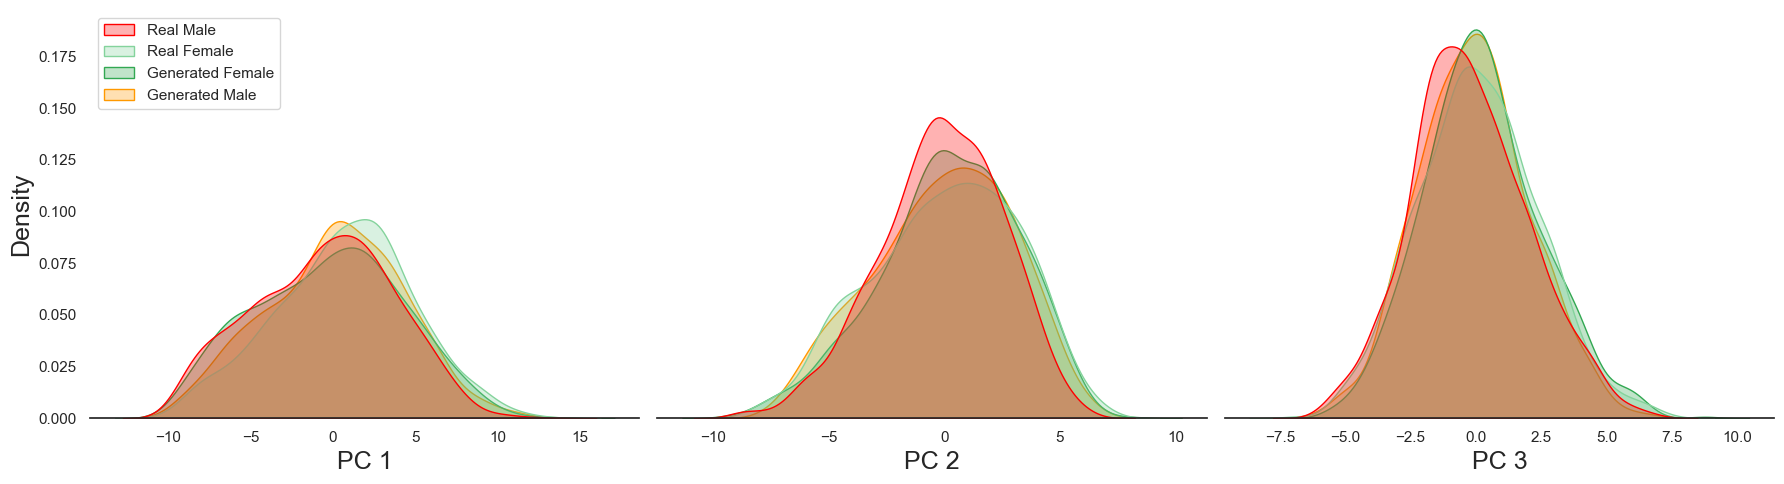

In [37]:
# --- Generate Plots ---
print("Generating density plots...")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Replace datasource labels for better legend
pca_df['datasource'] = pca_df['datasource'].replace({
    'cf_a': 'Generated Female',
    'cf_b': 'Generated Male',
    'test_a': 'Real Male',
    'test_b': 'Real Female'
})

# Define colors
palette = {
    'Real Male': 'red',
    'Real Female': '#84d39c',
    'Generated Female': '#32a852', # Green
    'Generated Male': '#ff9900'  # Orange
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ax in enumerate(axes, start=1):
    sns.kdeplot(
        data=pca_df,
        x=f'PC{i}',
        hue='datasource',
        palette=palette,
        fill=True,
        common_norm=False,
        alpha=0.3,
        ax=ax
    )
    ax.set_xlabel(f'PC {i}', fontsize=18)
    if i == 1:
        ax.set_ylabel('Density', fontsize=18)
    else:
        ax.set_ylabel('')
    sns.despine(ax=ax, left=True)
    # Remove legend from subplots 1 and 2
    if i != 1:
        ax.get_legend().remove()
    else:
        leg = ax.get_legend()
        leg.set_title('')
        leg.get_frame().set_facecolor('white')
        leg.set_bbox_to_anchor((0, 1))  # Top left corner of last subplot
        leg.set_loc('upper left')

plt.tight_layout()
plt.savefig("pca_padchest_sex.pdf")
plt.show()